<a href="https://www.kaggle.com/code/aahmedehab/gbpusd-1d-prediction?scriptVersionId=142136647" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# load data

In [2]:
file_path = '/kaggle/input/gbpusd-1d/GBPUSD1D.csv'

date_format = lambda x: datetime.strptime (x,'%Y.%m.%d')
df = pd.read_csv(file_path,parse_dates = ['Date'], date_parser = date_format)
df.set_index ('Date',inplace = True)
series = df ['Close'].values
time =  df.index.values
max_value = np.max (series)
series = series /max_value

# plot data

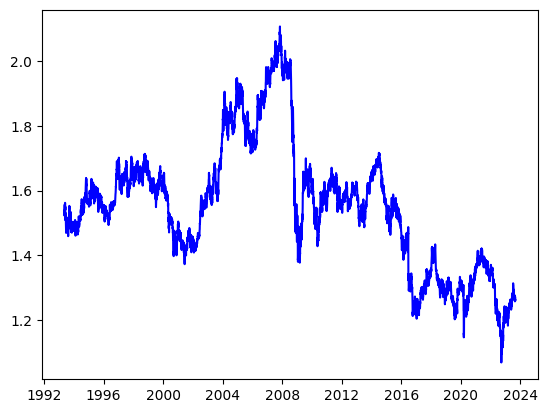

In [3]:
plt.plot (time,df ['Close'].values,c ='b')

# define gausian noise function

In [4]:
def add_gausian_noise(series):
  for i in range (series.shape[0]):
    series [i] = series [i] + np.random.uniform(-0.001,0.001)
  return series

# split data into train and test

In [5]:
split_time = 0.8
train_series = series [:int (split_time * series.shape[0])]
test_series = series [int (split_time * series.shape[0]) : ]

# define Dataset function

In [6]:
def Dataset (series,window_size,shuffle_buffer,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices (series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# create train and test dataset

In [7]:
window_size = 22
shuffle_buffer = 1000
batch_size = 16
train_dataset = Dataset (add_gausian_noise(train_series),window_size,shuffle_buffer,batch_size)
test_dataset = Dataset (test_series,window_size,shuffle_buffer,batch_size)

for window in train_dataset.take(1):
    print(f'shape of train feature: {window[0].shape}')
    print(f'shape of train label: {window[1].shape}')

for window in test_dataset.take(1):
    print(f'shape of test feature: {window[0].shape}')
    print(f'shape of test label: {window[1].shape}')

shape of train feature: (16, 22)
shape of train label: (16,)
shape of test feature: (16, 22)
shape of test label: (16,)


# build model

In [8]:
inputs = keras.layers.Input (shape = (window_size,1))
x = keras.layers.Conv1D(filters=32, kernel_size=5, padding="causal",activation="relu")(inputs)
x = keras.layers.Bidirectional( keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Bidirectional( keras.layers.LSTM(32))(x)
x = keras.layers.Dense (16,activation = 'relu')(x)
x = tf.keras.layers.Dense(1) (x)

model = keras.Model([inputs], outputs=x)
model.summary()

callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,verbose = 1,restore_best_weights = True),
            tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=tf.keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=1e-5),metrics=["mae"])
history = model.fit (train_dataset,epochs = 1000,callbacks=[callback],validation_data = test_dataset)
model.load_weights('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 22, 32)            192       
                                                                 
 bidirectional (Bidirectiona  (None, 22, 128)          49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17    

# plot loss and mae

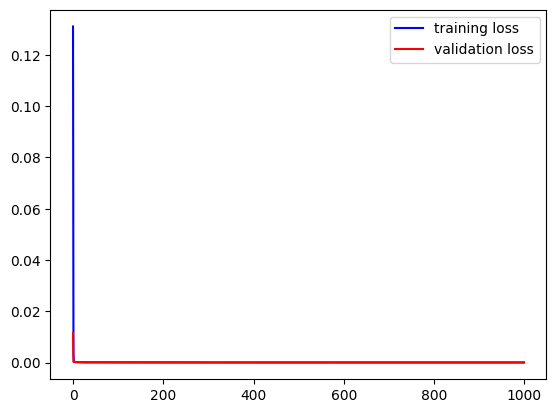

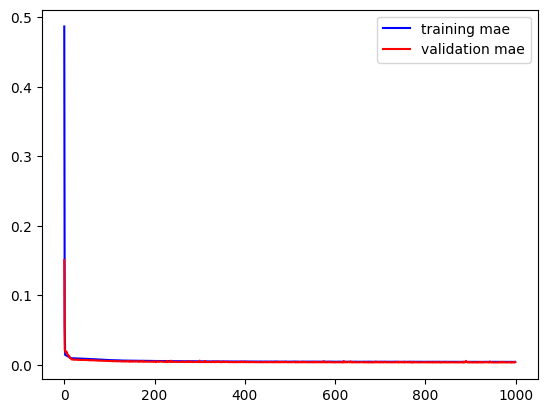

In [9]:
train_loss=history.history['loss']
val_loss = history.history['val_loss']
tarin_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(range (len (train_loss)),train_loss,c='b',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',label = 'validation loss')
plt.legend()
plt.show()

plt.plot(range (len (tarin_mae)),tarin_mae,c='b',label = 'training mae')
plt.plot (range (len (val_mae)),val_mae,c='r',label = 'validation mae')
plt.legend()
plt.show()

# test and plot data  

488/488 [==============================] - 4s 5ms/step


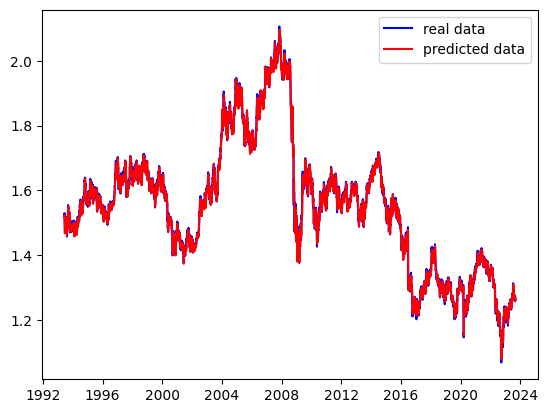

mean square error:0.00012997857993468642
mean absolute error:0.00843848753720522


In [10]:
predict_dataset = tf.data.Dataset.from_tensor_slices (series[:-1])
predict_dataset = predict_dataset.window(window_size , shift=1, drop_remainder=True)
predict_dataset = predict_dataset.flat_map(lambda window: window.batch(window_size))
predict_dataset = predict_dataset.batch(batch_size).prefetch(1)

tests = model.predict (predict_dataset)
tests = tests.reshape(-1)

series_plot = series * max_value
tests_plot = tests * max_value

plt.plot (time[window_size:],series_plot[window_size:] ,c ='b',label = 'real data' )
plt.plot (time[window_size:], tests_plot ,c ='r' ,label = 'predicted data')
plt.legend()
plt.show()

print(f'mean square error:{tf.keras.metrics.mean_squared_error(series_plot[window_size:], tests_plot).numpy()}')
print(f'mean absolute error:{tf.keras.metrics.mean_absolute_error(series_plot[window_size:], tests_plot).numpy()}')


# zoom on predicted chart

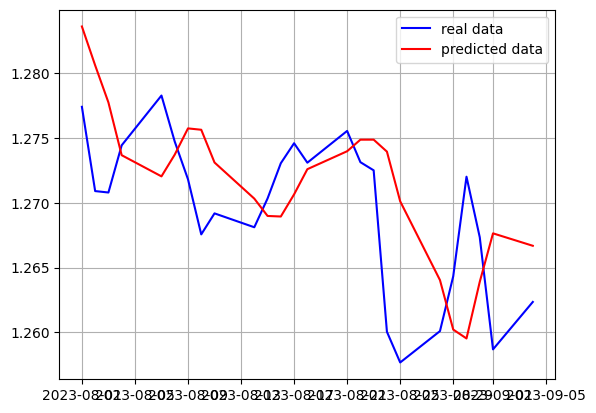

In [11]:
zoom = -25
plt.plot (time[zoom:],series_plot[zoom:] ,c ='b',label = 'real data' )
plt.plot (time[zoom:], tests_plot[zoom:] ,c ='r' ,label = 'predicted data')
plt.legend()
plt.grid (True)
plt.show()